In [35]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy import ndimage
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [36]:
# takes all images and convert them to grayscale. 
# return a dictionary that holds all images category by category. 
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat,0)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                category.append(img)
        images[filename] = category
    return images

images = load_images_from_folder(r'/content/drive/MyDrive/Dataset-Assignment 1/Training')  # take all images category by category 
test = load_images_from_folder(r'/content/drive/MyDrive/Dataset-Assignment 1/Test') # take test images 
    


In [37]:
# Creates descriptors using sift 
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds the descriptors but this is seperated class by class
def sift_feat(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
           
            
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_feat(images) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_feat(test)[1] 

(array([[110.,  51.,  24., ...,   0.,   0.,   0.],
        [144.,  32.,   9., ...,   0.,   0.,   0.],
        [151.,  32.,   4., ...,   0.,   0.,   0.],
        ...,
        [152.,  33.,  10., ...,   0.,   0.,   0.],
        [168.,  22.,   5., ...,   0.,   0.,   0.],
        [165.,  20.,   7., ...,   0.,   0.,   0.]]),
 array([1.49253731e-02, 1.85342068e+01, 3.70534882e+01, 5.55727696e+01,
        7.40920509e+01, 9.26113323e+01, 1.11130614e+02, 1.29649895e+02,
        1.48169177e+02, 1.66688458e+02, 1.85207739e+02]),
 <a list of 128 Lists of Patches objects>)

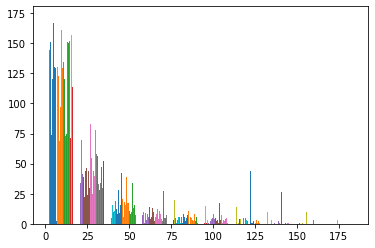

In [48]:
# A k-means clustering algorithm who takes 2 parameter which is number of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def k_means(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = k_means(200, descriptor_list) 
plt.hist(visual_words)

In [44]:
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [45]:
# Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class 
# And the second parameter is an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class. 
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 

In [46]:
# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def KNN(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #calling dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Calling knn function    
results_bowl = KNN(bovw_train, bovw_test) 

In [47]:
# Calculating the average accuracy and class based accuracies.  
def accur(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
# Calculates the accuracies and write the results to the console.       
accur(results_bowl) 

Average accuracy: %53.5

Class based accuracies: 

00008 : %90.0
00007 : %30.0
00009 : %70.0
00001 : %25.0
00006 : %40.0
00003 : %40.0
00005 : %35.0
00010 : %45.0
00004 : %65.0
00002 : %95.0
